# Trabajo Final Visión por Computadora II - CEIA - UBA
## Análisis Exploratorio de Datos (EDA)

**Dataset seleccionado**: Chest CT-Scan images Dataset (Kaggle).

El objetivo con respecto a este dataset es la detección de nódulos pulmonares en tomografías de tórax

## 1. Balanceo de clases

In [30]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cv2

CONTEO DE IMÁGENES POR CLASE

TRAIN:
--------------------------------------------------------------------------------
  normal                                            :  148 imágenes
  adenocarcinoma_left                               :  195 imágenes
  large.cell.carcinoma_left                         :  115 imágenes
  squamous.cell.carcinoma_left                      :  155 imágenes
  TOTAL                                             :  613 imágenes

VALID:
--------------------------------------------------------------------------------
  normal                                            :   13 imágenes
  adenocarcinoma_left                               :   23 imágenes
  large.cell.carcinoma_left                         :   21 imágenes
  squamous.cell.carcinoma_left                      :   15 imágenes
  TOTAL                                             :   72 imágenes

TEST:
--------------------------------------------------------------------------------
  normal                 

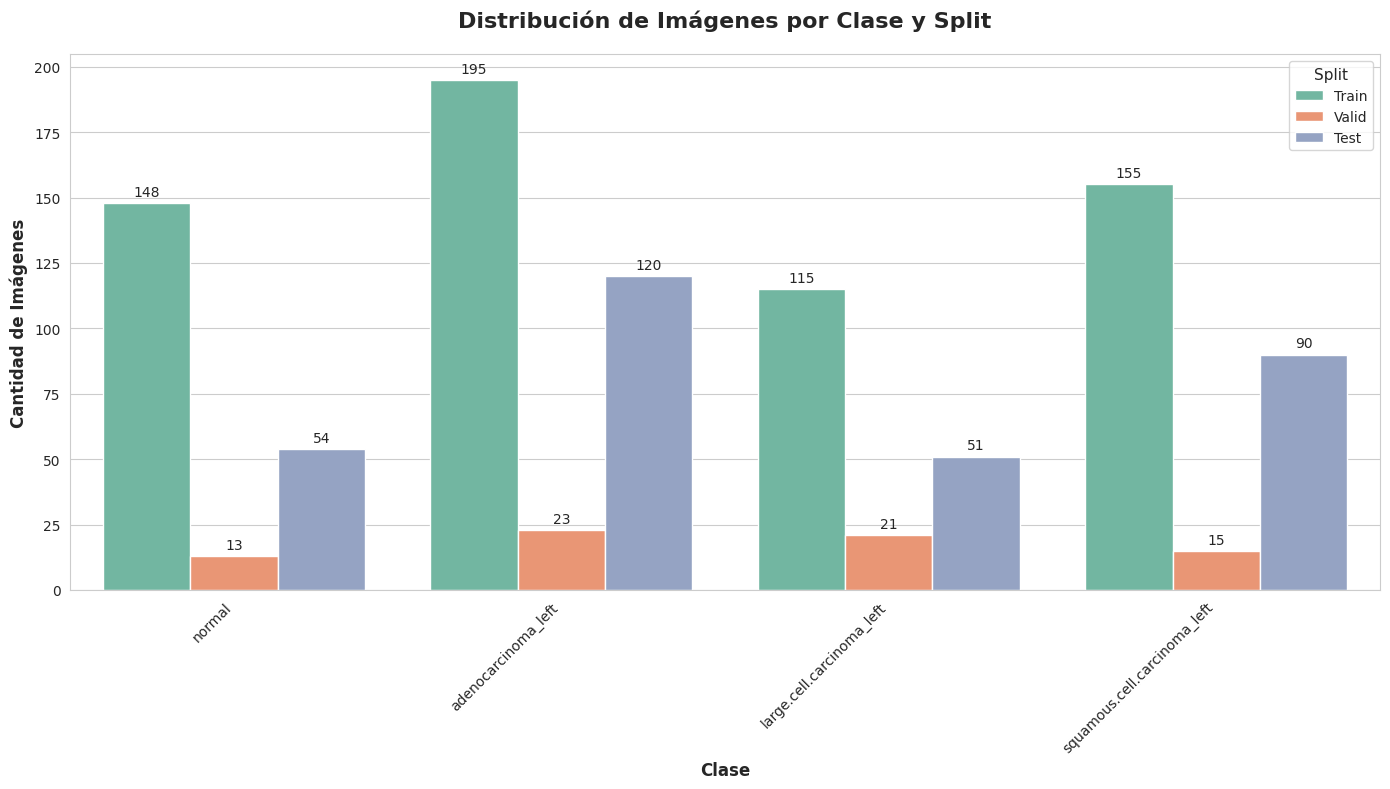

<Figure size 1400x800 with 0 Axes>

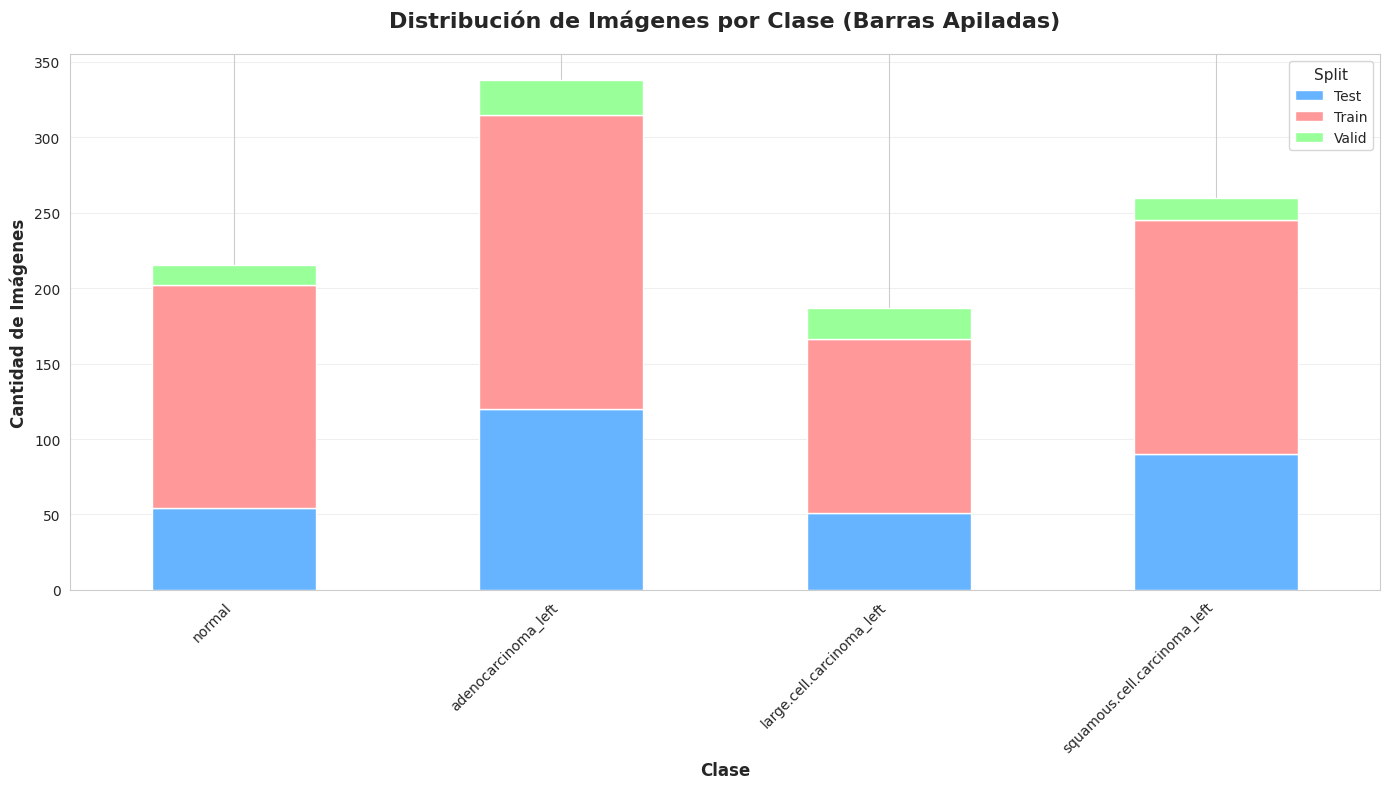

In [31]:
import os
from pathlib import Path
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ruta base del dataset
data_dir = Path("Data")

# Diccionario para almacenar conteos
counts = defaultdict(lambda: defaultdict(int))

# Extensiones de imagen válidas
image_extensions = {'.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'}

# Función para normalizar nombres de clases
def normalize_class_name(class_name):
    """Normaliza el nombre de la clase según el patrón: normal, adenocarcinoma_left, large.cell.carcinoma_left, squamous.cell.carcinoma_left"""
    if class_name == 'normal':
        return 'normal'
    elif class_name.startswith('adenocarcinoma'):
        return 'adenocarcinoma_left'
    elif class_name.startswith('large.cell.carcinoma'):
        return 'large.cell.carcinoma_left'
    elif class_name.startswith('squamous.cell.carcinoma'):
        return 'squamous.cell.carcinoma_left'
    else:
        return class_name

# Recorrer train, valid y test
for split in ['train', 'valid', 'test']:
    split_path = data_dir / split
    if split_path.exists():
        # Recorrer cada subcarpeta (clase)
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                # Contar imágenes en la carpeta
                image_count = sum(1 for file in class_folder.iterdir() 
                                if file.is_file() and file.suffix in image_extensions)
                # Normalizar nombre de clase
                normalized_class = normalize_class_name(class_name)
                counts[split][normalized_class] += image_count

# Mostrar resultados
print("=" * 80)
print("CONTEO DE IMÁGENES POR CLASE")
print("=" * 80)

# Mostrar por split
for split in ['train', 'valid', 'test']:
    if split in counts:
        print(f"\n{split.upper()}:")
        print("-" * 80)
        total_split = 0
        for class_name in ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']:
            count = counts[split].get(class_name, 0)
            print(f"  {class_name:50s}: {count:4d} imágenes")
            total_split += count
        print(f"  {'TOTAL':50s}: {total_split:4d} imágenes")

# Resumen por clase (sumando todos los splits)
print("\n" + "=" * 80)
print("RESUMEN TOTAL POR CLASE (train + valid + test)")
print("=" * 80)

class_totals = defaultdict(int)
for split in ['train', 'valid', 'test']:
    if split in counts:
        for class_name, count in counts[split].items():
            class_totals[class_name] += count

for class_name in ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']:
    total = class_totals.get(class_name, 0)
    print(f"  {class_name:50s}: {total:4d} imágenes")

print(f"\n{'TOTAL GENERAL':50s}: {sum(class_totals.values()):4d} imágenes")
print("=" * 80)

# Crear DataFrame para visualización
data_list = []
for split in ['train', 'valid', 'test']:
    if split in counts:
        for class_name in ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']:
            count = counts[split].get(class_name, 0)
            data_list.append({
                'Split': split.capitalize(),
                'Clase': class_name,
                'Cantidad': count
            })

df = pd.DataFrame(data_list)

# Configurar estilo de seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Crear gráfico de barras agrupadas
ax = sns.barplot(data=df, x='Clase', y='Cantidad', hue='Split', palette='Set2')
plt.title('Distribución de Imágenes por Clase y Split', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Clase', fontsize=12, fontweight='bold')
plt.ylabel('Cantidad de Imágenes', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Split', title_fontsize=11, fontsize=10)

# Agregar valores en las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

# Crear gráfico de barras apiladas
plt.figure(figsize=(14, 8))
df_pivot = df.pivot(index='Clase', columns='Split', values='Cantidad')
df_pivot = df_pivot.reindex(['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left'])

ax2 = df_pivot.plot(kind='bar', stacked=True, color=['#66b3ff', '#ff9999', '#99ff99'], figsize=(14, 8))
plt.title('Distribución de Imágenes por Clase (Barras Apiladas)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Clase', fontsize=12, fontweight='bold')
plt.ylabel('Cantidad de Imágenes', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Split', title_fontsize=11, fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Tamaño imagenes

Analizando tamaños de imágenes...

ESTADÍSTICAS DE TAMAÑOS DE IMÁGENES

📊 ESTADÍSTICAS GENERALES:
--------------------------------------------------------------------------------
Total de imágenes analizadas: 1000

Ancho (Width):
  Mínimo: 168 px
  Máximo: 1200 px
  Promedio: 447.00 px
  Mediana: 419.00 px

Alto (Height):
  Mínimo: 110 px
  Máximo: 874 px
  Promedio: 317.78 px
  Mediana: 296.00 px

ESTADÍSTICAS POR SPLIT

TRAIN:
  Cantidad: 613 imágenes
  Ancho: 168 - 1200 px (promedio: 435.8 px)
  Alto: 110 - 874 px (promedio: 303.3 px)

VALID:
  Cantidad: 72 imágenes
  Ancho: 315 - 940 px (promedio: 437.8 px)
  Alto: 181 - 627 px (promedio: 299.5 px)

TEST:
  Cantidad: 315 imágenes
  Ancho: 360 - 940 px (promedio: 470.8 px)
  Alto: 232 - 700 px (promedio: 350.1 px)

ESTADÍSTICAS POR CLASE

normal:
  Cantidad: 215 imágenes
  Ancho: 224 - 940 px (promedio: 593.6 px)
  Alto: 210 - 700 px (promedio: 445.1 px)

adenocarcinoma_left:
  Cantidad: 338 imágenes
  Ancho: 172 - 1200 px (promedio

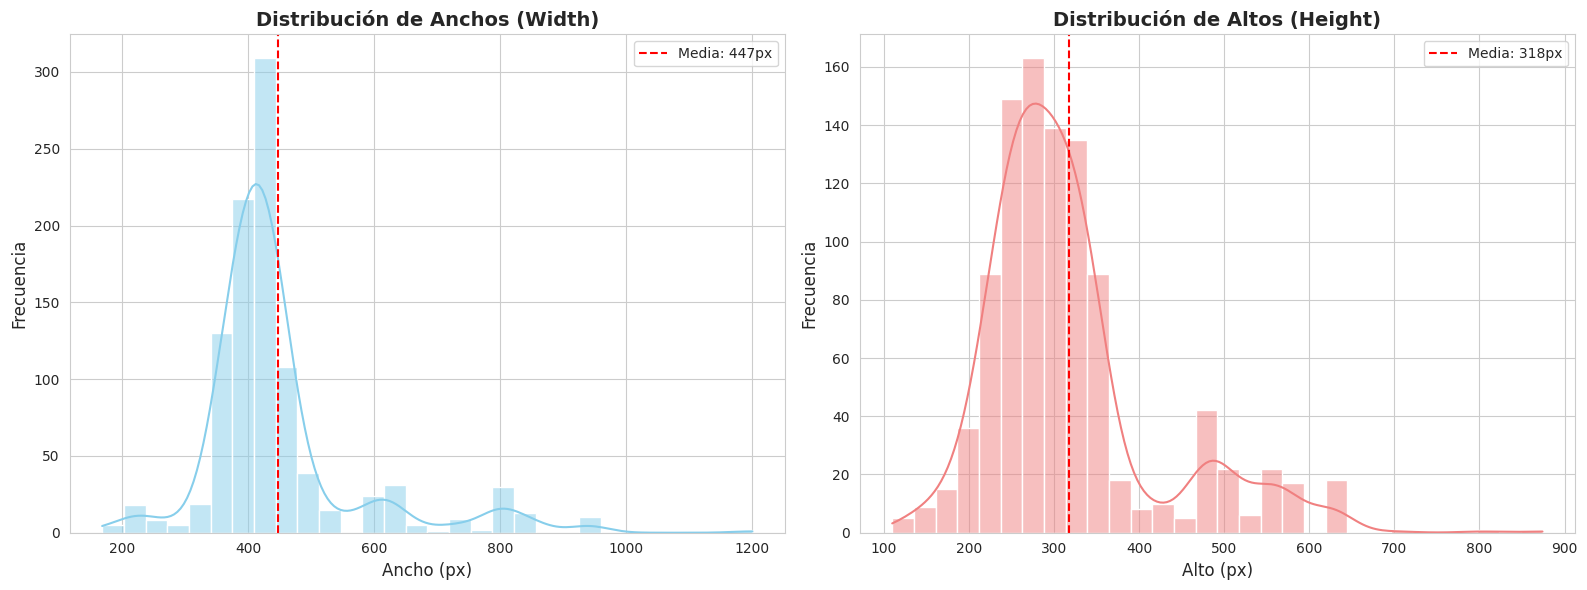

/tmp/ipykernel_106092/271990204.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sizes, x='Clase', y='Ancho', ax=axes[0], palette='Set3')
/tmp/ipykernel_106092/271990204.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sizes, x='Clase', y='Alto', ax=axes[1], palette='Set3')


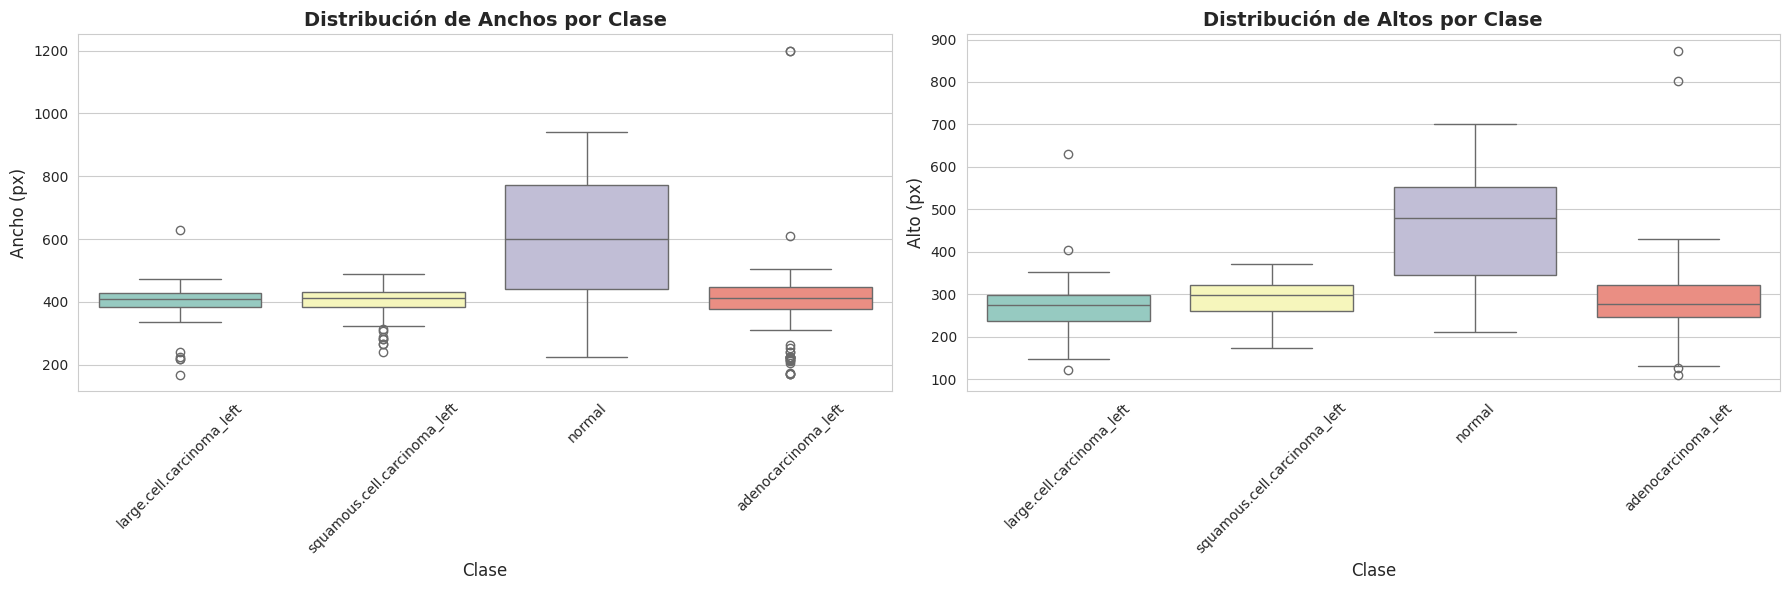

In [32]:
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Ruta base del dataset
data_dir = Path("Data")

# Extensiones de imagen válidas
image_extensions = {'.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'}

# Función para normalizar nombres de clases
def normalize_class_name(class_name):
    """Normaliza el nombre de la clase según el patrón"""
    if class_name == 'normal':
        return 'normal'
    elif class_name.startswith('adenocarcinoma'):
        return 'adenocarcinoma_left'
    elif class_name.startswith('large.cell.carcinoma'):
        return 'large.cell.carcinoma_left'
    elif class_name.startswith('squamous.cell.carcinoma'):
        return 'squamous.cell.carcinoma_left'
    else:
        return class_name

# Lista para almacenar información de las imágenes
image_data = []

# Recorrer train, valid y test
print("Analizando tamaños de imágenes...")
for split in ['train', 'valid', 'test']:
    split_path = data_dir / split
    if split_path.exists():
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                normalized_class = normalize_class_name(class_name)
                
                # Recorrer todas las imágenes en la carpeta
                for image_file in class_folder.iterdir():
                    if image_file.is_file() and image_file.suffix in image_extensions:
                        try:
                            with Image.open(image_file) as img:
                                width, height = img.size
                                image_data.append({
                                    'Split': split,
                                    'Clase': normalized_class,
                                    'Ancho': width,
                                    'Alto': height,
                                    'Total_Pixeles': width * height,
                                    'Archivo': image_file.name
                                })
                        except Exception as e:
                            print(f"Error al leer {image_file}: {e}")

# Crear DataFrame
df_sizes = pd.DataFrame(image_data)

# Mostrar estadísticas generales
print("\n" + "=" * 80)
print("ESTADÍSTICAS DE TAMAÑOS DE IMÁGENES")
print("=" * 80)

print("\n📊 ESTADÍSTICAS GENERALES:")
print("-" * 80)
print(f"Total de imágenes analizadas: {len(df_sizes)}")
print(f"\nAncho (Width):")
print(f"  Mínimo: {df_sizes['Ancho'].min()} px")
print(f"  Máximo: {df_sizes['Ancho'].max()} px")
print(f"  Promedio: {df_sizes['Ancho'].mean():.2f} px")
print(f"  Mediana: {df_sizes['Ancho'].median():.2f} px")
print(f"\nAlto (Height):")
print(f"  Mínimo: {df_sizes['Alto'].min()} px")
print(f"  Máximo: {df_sizes['Alto'].max()} px")
print(f"  Promedio: {df_sizes['Alto'].mean():.2f} px")
print(f"  Mediana: {df_sizes['Alto'].median():.2f} px")


# Estadísticas por split
print("\n" + "=" * 80)
print("ESTADÍSTICAS POR SPLIT")
print("=" * 80)
for split in ['train', 'valid', 'test']:
    df_split = df_sizes[df_sizes['Split'] == split]
    if len(df_split) > 0:
        print(f"\n{split.upper()}:")
        print(f"  Cantidad: {len(df_split)} imágenes")
        print(f"  Ancho: {df_split['Ancho'].min()} - {df_split['Ancho'].max()} px (promedio: {df_split['Ancho'].mean():.1f} px)")
        print(f"  Alto: {df_split['Alto'].min()} - {df_split['Alto'].max()} px (promedio: {df_split['Alto'].mean():.1f} px)")

# Estadísticas por clase
print("\n" + "=" * 80)
print("ESTADÍSTICAS POR CLASE")
print("=" * 80)
for clase in ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']:
    df_clase = df_sizes[df_sizes['Clase'] == clase]
    if len(df_clase) > 0:
        print(f"\n{clase}:")
        print(f"  Cantidad: {len(df_clase)} imágenes")
        print(f"  Ancho: {df_clase['Ancho'].min()} - {df_clase['Ancho'].max()} px (promedio: {df_clase['Ancho'].mean():.1f} px)")
        print(f"  Alto: {df_clase['Alto'].min()} - {df_clase['Alto'].max()} px (promedio: {df_clase['Alto'].mean():.1f} px)")

# Tamaños únicos
print("\n" + "=" * 80)
print("TAMAÑOS ÚNICOS ENCONTRADOS")
print("=" * 80)
unique_sizes = df_sizes.groupby(['Ancho', 'Alto']).size().reset_index(name='Cantidad')
unique_sizes = unique_sizes.sort_values('Cantidad', ascending=False)
print(f"\nTotal de tamaños únicos: {len(unique_sizes)}")
print("\nTop 10 tamaños más comunes:")
print(unique_sizes.head(10).to_string(index=False))

# Visualizaciones
sns.set_style("whitegrid")

# 1. Distribución de anchos y altos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=df_sizes, x='Ancho', bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Anchos (Width)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Ancho (px)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].axvline(df_sizes['Ancho'].mean(), color='red', linestyle='--', label=f'Media: {df_sizes["Ancho"].mean():.0f}px')
axes[0].legend()

sns.histplot(data=df_sizes, x='Alto', bins=30, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Distribución de Altos (Height)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Alto (px)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].axvline(df_sizes['Alto'].mean(), color='red', linestyle='--', label=f'Media: {df_sizes["Alto"].mean():.0f}px')
axes[1].legend()

plt.tight_layout()
plt.show()



# 4. Box plots por clase
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=df_sizes, x='Clase', y='Ancho', ax=axes[0], palette='Set3')
axes[0].set_title('Distribución de Anchos por Clase', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase', fontsize=12)
axes[0].set_ylabel('Ancho (px)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df_sizes, x='Clase', y='Alto', ax=axes[1], palette='Set3')
axes[1].set_title('Distribución de Altos por Clase', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Clase', fontsize=12)
axes[1].set_ylabel('Alto (px)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



## 3. Análisis de Histogramas de Colores y Separabilidad de Clases


In [33]:
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cv2

# Ruta base del dataset
data_dir = Path("Data")

# Extensiones de imagen válidas
image_extensions = {'.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'}

# Función para normalizar nombres de clases
def normalize_class_name(class_name):
    """Normaliza el nombre de la clase según el patrón"""
    if class_name == 'normal':
        return 'normal'
    elif class_name.startswith('adenocarcinoma'):
        return 'adenocarcinoma_left'
    elif class_name.startswith('large.cell.carcinoma'):
        return 'large.cell.carcinoma_left'
    elif class_name.startswith('squamous.cell.carcinoma'):
        return 'squamous.cell.carcinoma_left'
    else:
        return class_name

# Función para extraer histograma de color de una imagen
def extract_color_histogram(image_path, bins=256):
    """Extrae histograma RGB de una imagen"""
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        
        # Convertir BGR a RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Calcular histogramas para cada canal
        hist_r = cv2.calcHist([img_rgb], [0], None, [bins], [0, 256])
        hist_g = cv2.calcHist([img_rgb], [1], None, [bins], [0, 256])
        hist_b = cv2.calcHist([img_rgb], [2], None, [bins], [0, 256])
        
        # Normalizar histogramas
        hist_r = hist_r.flatten() / (img_rgb.shape[0] * img_rgb.shape[1])
        hist_g = hist_g.flatten() / (img_rgb.shape[0] * img_rgb.shape[1])
        hist_b = hist_b.flatten() / (img_rgb.shape[0] * img_rgb.shape[1])
        
        # Concatenar histogramas
        hist_combined = np.concatenate([hist_r, hist_g, hist_b])
        
        return hist_combined
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

# Función para extraer características estadísticas del histograma
def extract_histogram_features(hist):
    """Extrae características estadísticas del histograma"""
    if hist is None:
        return None
    
    # Dividir en canales R, G, B
    bins = len(hist) // 3
    hist_r = hist[:bins]
    hist_g = hist[bins:2*bins]
    hist_b = hist[2*bins:]
    
    features = []
    for channel_hist in [hist_r, hist_g, hist_b]:
        # Estadísticas del histograma
        features.extend([
            np.mean(channel_hist),      # Media
            np.std(channel_hist),       # Desviación estándar
            np.median(channel_hist),    # Mediana
            np.percentile(channel_hist, 25),  # Q1
            np.percentile(channel_hist, 75),  # Q3
            np.max(channel_hist),      # Máximo
            np.argmax(channel_hist),    # Moda (índice del valor máximo)
            np.sum(channel_hist > np.mean(channel_hist)),  # Píxeles sobre la media
        ])
    
    return np.array(features)

# Recopilar datos de imágenes (usar solo train para análisis más rápido)
print("Extrayendo histogramas de colores de las imágenes...")
histogram_data = []
histogram_features = []
class_labels = []
image_paths = []

# Limitar a train para análisis más rápido (puedes cambiar a ['train', 'valid', 'test'] para todo)
for split in ['train']:
    split_path = data_dir / split
    if split_path.exists():
        for class_folder in split_path.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name
                normalized_class = normalize_class_name(class_name)
                
                # Recorrer todas las imágenes en la carpeta
                for image_file in class_folder.iterdir():
                    if image_file.is_file() and image_file.suffix in image_extensions:
                        hist = extract_color_histogram(image_file)
                        if hist is not None:
                            histogram_data.append(hist)
                            features = extract_histogram_features(hist)
                            if features is not None:
                                histogram_features.append(features)
                                class_labels.append(normalized_class)
                                image_paths.append(str(image_file))

print(f"Procesadas {len(histogram_data)} imágenes")
print(f"Dimensiones del histograma: {len(histogram_data[0])}")
print(f"Dimensiones de características: {len(histogram_features[0])}")

# Convertir a arrays numpy
histogram_data = np.array(histogram_data)
histogram_features = np.array(histogram_features)
class_labels = np.array(class_labels)

print(f"\nClases encontradas: {np.unique(class_labels)}")
print(f"Cantidad por clase:")
for clase in np.unique(class_labels):
    print(f"  {clase}: {np.sum(class_labels == clase)}")


Extrayendo histogramas de colores de las imágenes...
Procesadas 613 imágenes
Dimensiones del histograma: 768
Dimensiones de características: 24

Clases encontradas: ['adenocarcinoma_left' 'large.cell.carcinoma_left' 'normal'
 'squamous.cell.carcinoma_left']
Cantidad por clase:
  adenocarcinoma_left: 195
  large.cell.carcinoma_left: 115
  normal: 148
  squamous.cell.carcinoma_left: 155


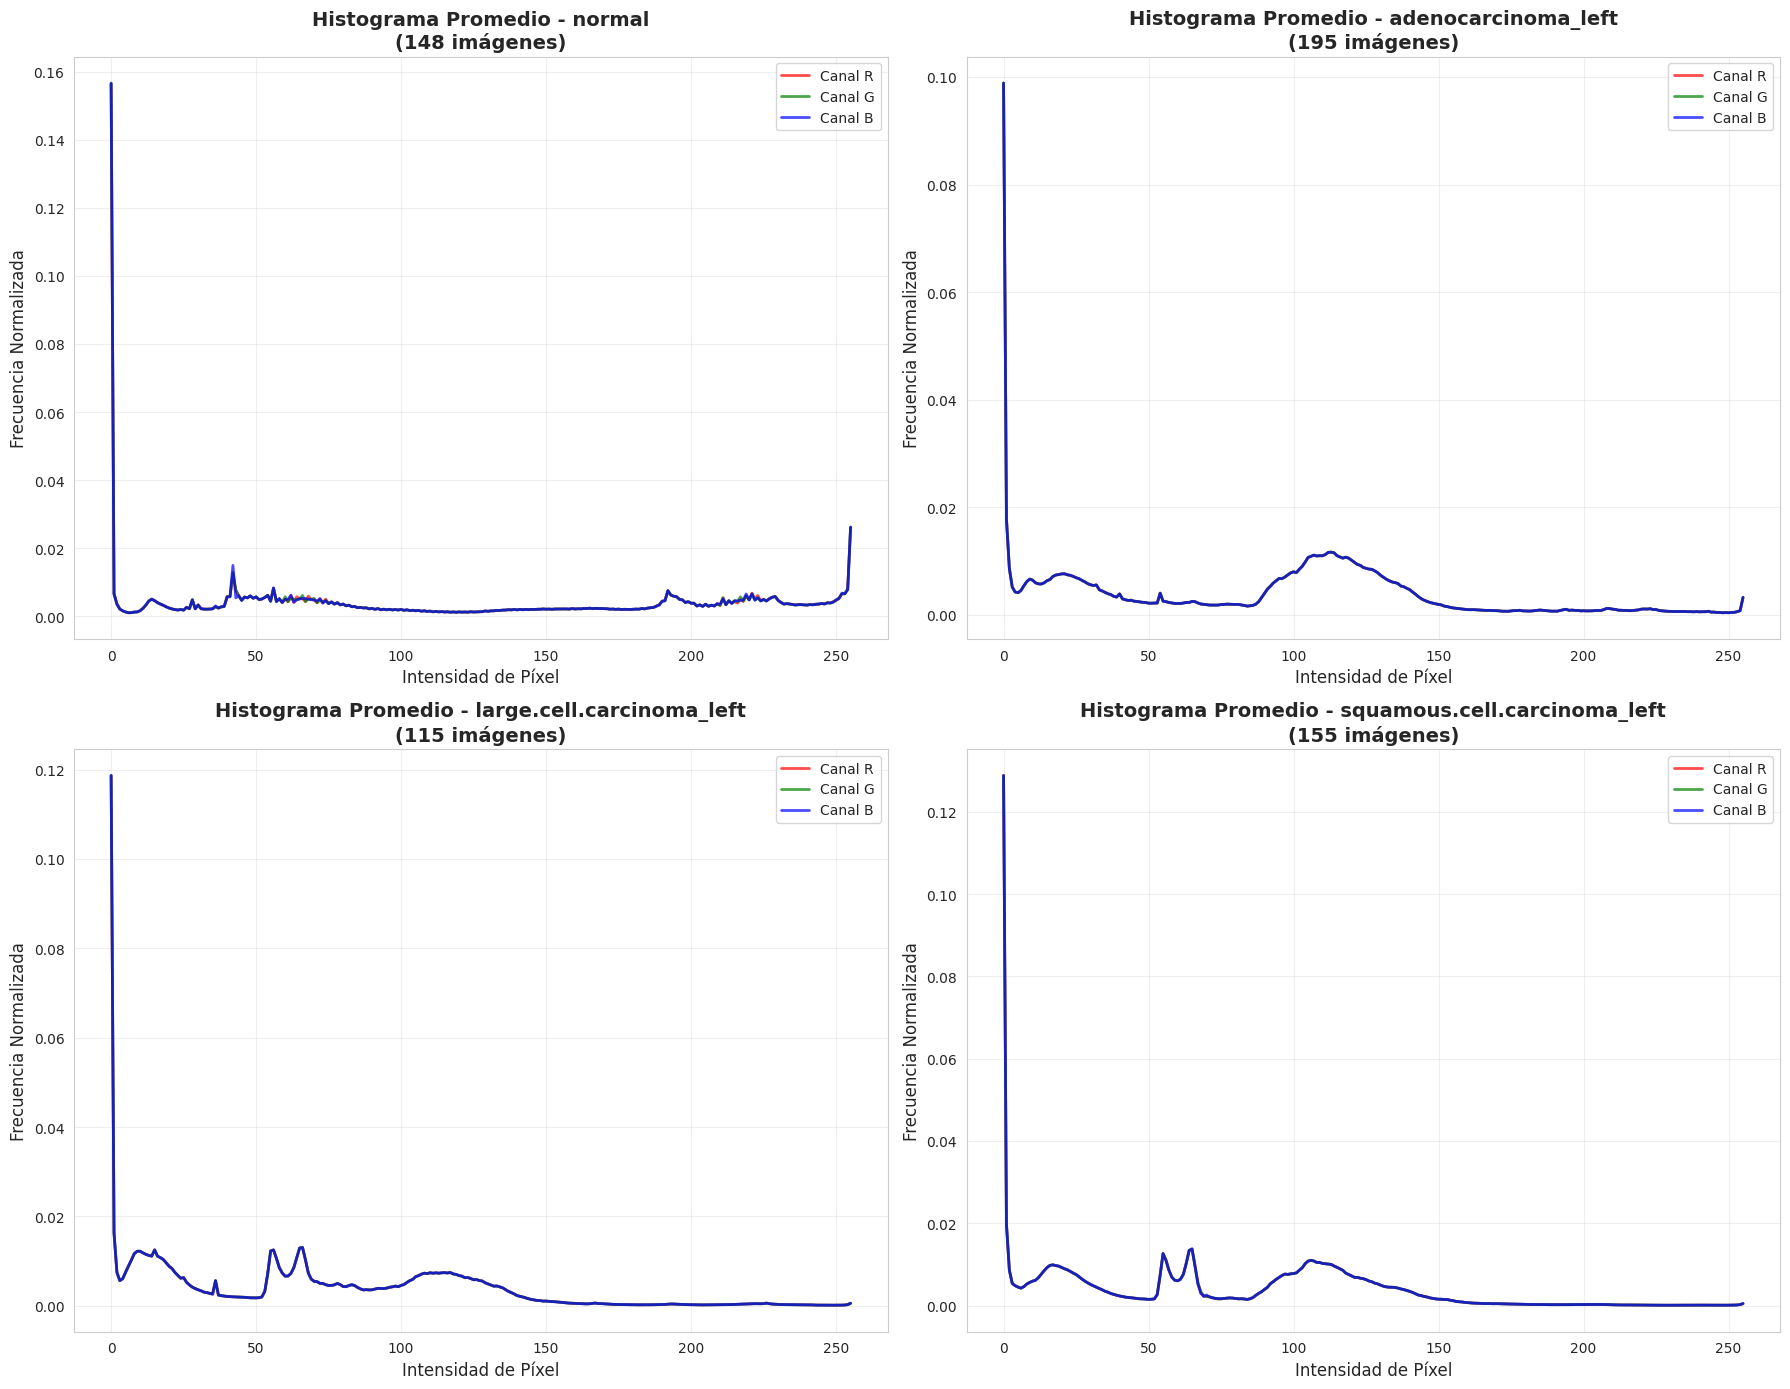

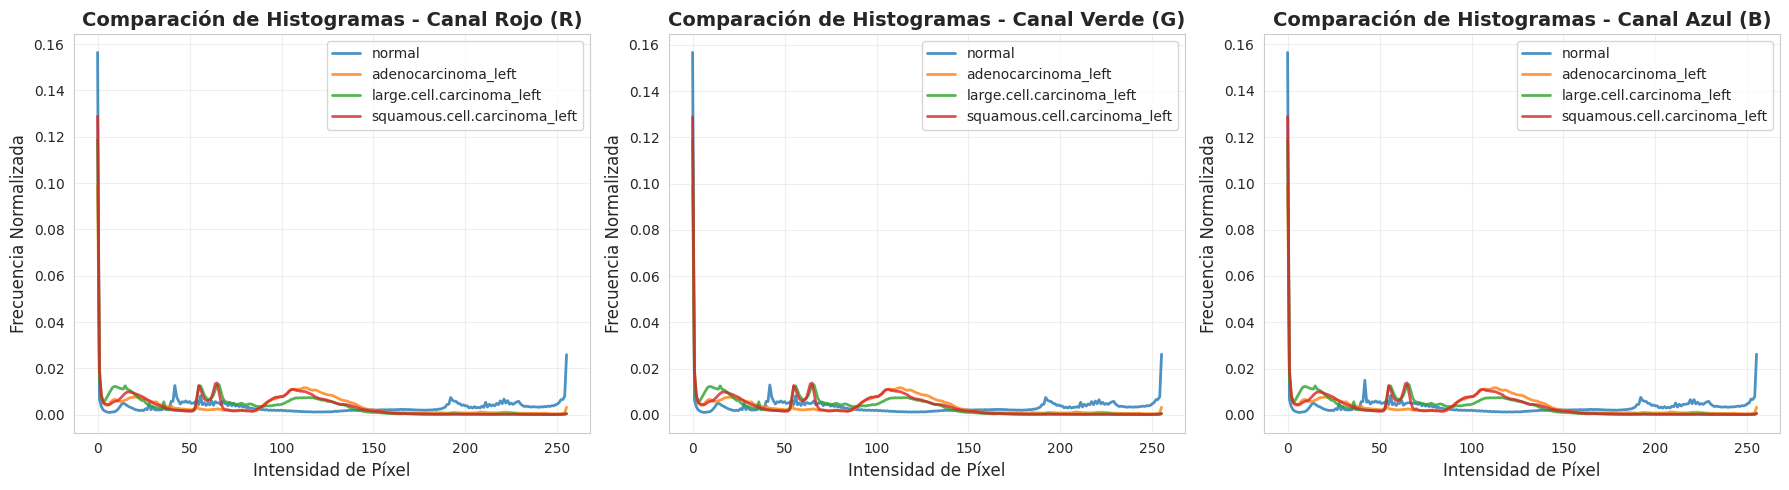

In [34]:
# Visualización de histogramas de colores por clase
sns.set_style("whitegrid")

# Verificar que las variables necesarias existan
if 'histogram_data' not in globals() or len(histogram_data) == 0:
    raise ValueError("Error: Primero ejecuta la celda anterior para extraer histogramas")

# Calcular histogramas promedio por clase
classes = ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']
colors = ['red', 'green', 'blue']
color_names = ['Rojo (R)', 'Verde (G)', 'Azul (B)']

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, clase in enumerate(classes):
    ax = axes[idx]
    class_mask = class_labels == clase
    if np.sum(class_mask) > 0:
        # Calcular histograma promedio para esta clase
        class_histograms = histogram_data[class_mask]
        avg_hist = np.mean(class_histograms, axis=0)
        
        bins = len(avg_hist) // 3
        hist_r = avg_hist[:bins]
        hist_g = avg_hist[bins:2*bins]
        hist_b = avg_hist[2*bins:]
        
        # Graficar histogramas de cada canal
        x = np.arange(bins)
        ax.plot(x, hist_r, color='red', alpha=0.7, label='Canal R', linewidth=2)
        ax.plot(x, hist_g, color='green', alpha=0.7, label='Canal G', linewidth=2)
        ax.plot(x, hist_b, color='blue', alpha=0.7, label='Canal B', linewidth=2)
        
        ax.set_title(f'Histograma Promedio - {clase}\n({np.sum(class_mask)} imágenes)', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Intensidad de Píxel', fontsize=12)
        ax.set_ylabel('Frecuencia Normalizada', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'No hay imágenes para {clase}', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'Histograma - {clase}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Comparación de histogramas superpuestos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for channel_idx, (channel_name, channel_color) in enumerate(zip(['Rojo (R)', 'Verde (G)', 'Azul (B)'], 
                                                                  ['red', 'green', 'blue'])):
    ax = axes[channel_idx]
    
    bins = len(histogram_data[0]) // 3
    start_idx = channel_idx * bins
    end_idx = (channel_idx + 1) * bins
    
    for clase in classes:
        class_mask = class_labels == clase
        if np.sum(class_mask) > 0:
            class_histograms = histogram_data[class_mask]
            avg_hist = np.mean(class_histograms[:, start_idx:end_idx], axis=0)
            x = np.arange(bins)
            ax.plot(x, avg_hist, label=clase, linewidth=2, alpha=0.8)
    
    ax.set_title(f'Comparación de Histogramas - Canal {channel_name}', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Intensidad de Píxel', fontsize=12)
    ax.set_ylabel('Frecuencia Normalizada', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


ANÁLISIS DE SEPARABILIDAD DE CLASES

Aplicando PCA para reducción inicial...
Número de características: 24, muestras: 613, usando 24 componentes PCA
Varianza explicada por los primeros 24 componentes PCA: 1.0000

Aplicando t-SNE (esto puede tardar unos minutos)...
t-SNE completado!


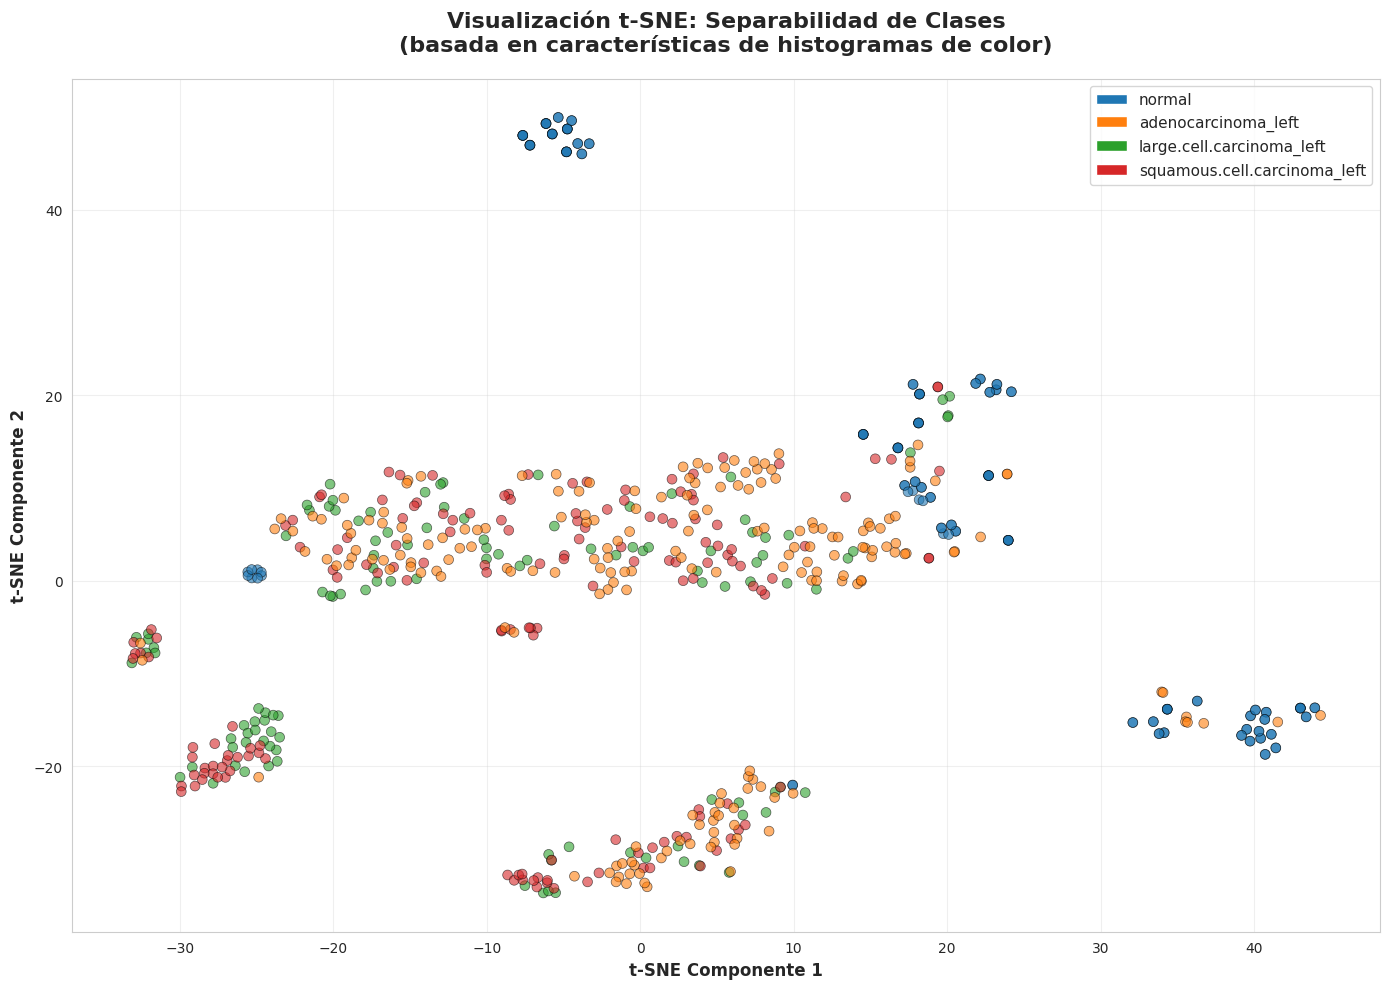

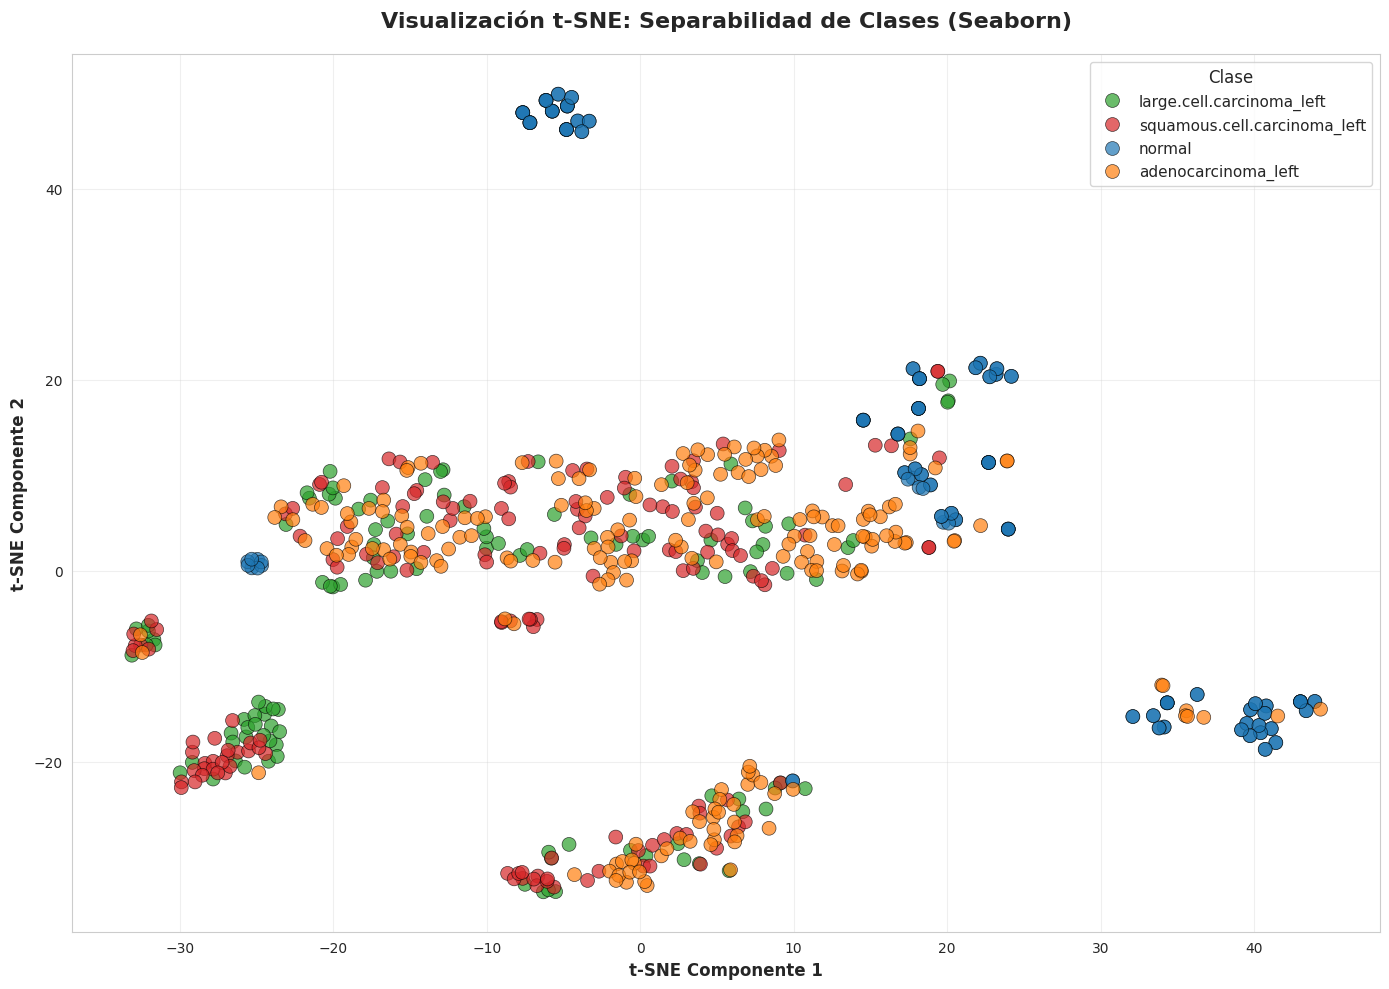

In [35]:
# Análisis de separabilidad con t-SNE y PCA
print("=" * 80)
print("ANÁLISIS DE SEPARABILIDAD DE CLASES")
print("=" * 80)

# Verificar que las variables necesarias existan
if 'histogram_features' not in globals() or len(histogram_features) == 0:
    raise ValueError("Error: Primero ejecuta la celda anterior para extraer histogramas")

# Normalizar características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(histogram_features)

# Aplicar PCA primero para reducir dimensionalidad antes de t-SNE
print("\nAplicando PCA para reducción inicial...")
# Ajustar número de componentes al mínimo entre 50 y el número de características disponibles
n_features = features_scaled.shape[1]
n_samples = features_scaled.shape[0]
# PCA puede usar hasta min(n_samples, n_features) componentes
max_components = min(n_samples, n_features)
n_components_pca = min(50, max_components)
print(f"Número de características: {n_features}, muestras: {n_samples}, usando {n_components_pca} componentes PCA")
pca = PCA(n_components=n_components_pca)
features_pca = pca.fit_transform(features_scaled)
print(f"Varianza explicada por los primeros {n_components_pca} componentes PCA: {pca.explained_variance_ratio_.sum():.4f}")

# Aplicar t-SNE
print("\nAplicando t-SNE (esto puede tardar unos minutos)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=0)
features_tsne = tsne.fit_transform(features_pca)
print("t-SNE completado!")

# Crear DataFrame para visualización
df_tsne = pd.DataFrame({
    't-SNE 1': features_tsne[:, 0],
    't-SNE 2': features_tsne[:, 1],
    'Clase': class_labels
})

# Definir clases y paleta de colores
classes = ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']
palette = {'normal': '#1f77b4', 
           'adenocarcinoma_left': '#ff7f0e', 
           'large.cell.carcinoma_left': '#2ca02c', 
           'squamous.cell.carcinoma_left': '#d62728'}

# Visualización t-SNE
plt.figure(figsize=(14, 10))

scatter = plt.scatter(df_tsne['t-SNE 1'], df_tsne['t-SNE 2'], 
                     c=df_tsne['Clase'].map(palette), 
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Crear leyenda manual
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=palette[clase], label=clase) 
                   for clase in classes if clase in df_tsne['Clase'].values]
plt.legend(handles=legend_elements, loc='best', fontsize=11)

plt.title('Visualización t-SNE: Separabilidad de Clases\n(basada en características de histogramas de color)', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('t-SNE Componente 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Componente 2', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualización con seaborn
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df_tsne, x='t-SNE 1', y='t-SNE 2', hue='Clase', 
               palette=palette, s=100, alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title('Visualización t-SNE: Separabilidad de Clases (Seaborn)', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('t-SNE Componente 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Componente 2', fontsize=12, fontweight='bold')
plt.legend(title='Clase', title_fontsize=12, fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Aplicando PCA a 2 dimensiones para comparación...
Varianza explicada por PCA 2D: 0.7038 (70.38%)


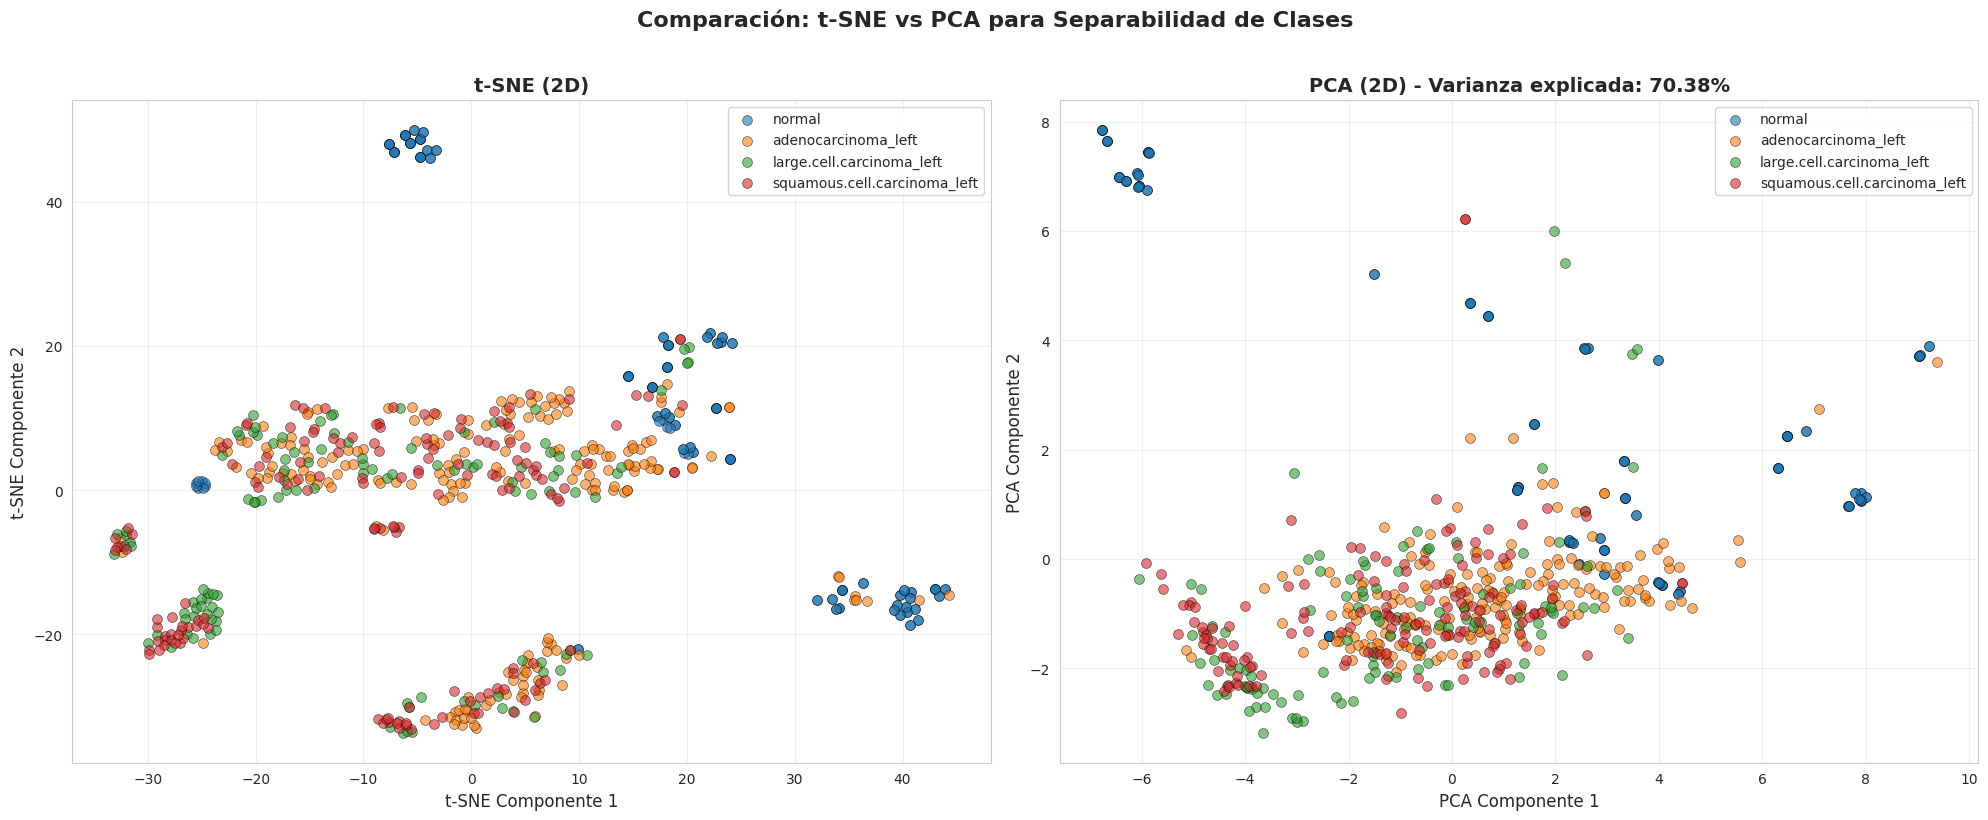


ANÁLISIS CUANTITATIVO DE SEPARABILIDAD

📊 Métricas para t-SNE:
  Distancia entre adenocarcinoma_left y large.cell.carcinoma_left: 12.5189
  Distancia entre adenocarcinoma_left y normal: 20.6795
  Distancia entre adenocarcinoma_left y squamous.cell.carcinoma_left: 11.0301
  Distancia entre large.cell.carcinoma_left y normal: 32.3524
  Distancia entre large.cell.carcinoma_left y squamous.cell.carcinoma_left: 1.6701
  Distancia entre normal y squamous.cell.carcinoma_left: 31.1290
  Dispersión intra-clase adenocarcinoma_left: 18.1284
  Dispersión intra-clase large.cell.carcinoma_left: 19.2982
  Dispersión intra-clase normal: 26.0001
  Dispersión intra-clase squamous.cell.carcinoma_left: 19.2681

  Ratio Separación/Dispersión: 0.8818
  (Valores más altos indican mejor separabilidad)

📊 Métricas para PCA:
  Distancia entre adenocarcinoma_left y large.cell.carcinoma_left: 1.8910
  Distancia entre adenocarcinoma_left y normal: 3.5756
  Distancia entre adenocarcinoma_left y squamous.cell.carci

In [36]:
# Comparación con PCA (2D)
print("\nAplicando PCA a 2 dimensiones para comparación...")

# Verificar que las variables necesarias existan
if 'features_scaled' not in globals():
    raise ValueError("Error: Primero ejecuta la celda anterior para calcular features_scaled")

pca_2d = PCA(n_components=2, random_state=42)
features_pca_2d = pca_2d.fit_transform(features_scaled)
variance_explained = pca_2d.explained_variance_ratio_.sum()
print(f"Varianza explicada por PCA 2D: {variance_explained:.4f} ({variance_explained*100:.2f}%)")

# Crear DataFrame para PCA
df_pca = pd.DataFrame({
    'PCA 1': features_pca_2d[:, 0],
    'PCA 2': features_pca_2d[:, 1],
    'Clase': class_labels
})

# Definir clases y paleta si no están definidas
if 'classes' not in globals():
    classes = ['normal', 'adenocarcinoma_left', 'large.cell.carcinoma_left', 'squamous.cell.carcinoma_left']
if 'palette' not in globals():
    palette = {'normal': '#1f77b4', 
               'adenocarcinoma_left': '#ff7f0e', 
               'large.cell.carcinoma_left': '#2ca02c', 
               'squamous.cell.carcinoma_left': '#d62728'}

# Visualización comparativa: t-SNE vs PCA
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# t-SNE
ax1 = axes[0]
if 'df_tsne' in globals():
    for clase in classes:
        mask = df_tsne['Clase'] == clase
        if np.sum(mask) > 0:
            ax1.scatter(df_tsne.loc[mask, 't-SNE 1'], df_tsne.loc[mask, 't-SNE 2'], 
                       c=palette[clase], label=clase, alpha=0.6, s=50, 
                       edgecolors='black', linewidth=0.5)
    ax1.set_title('t-SNE (2D)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE Componente 1', fontsize=12)
    ax1.set_ylabel('t-SNE Componente 2', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'Ejecuta la celda anterior\npara ver t-SNE', 
            ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('t-SNE (2D)', fontsize=14, fontweight='bold')

# PCA
ax2 = axes[1]
for clase in classes:
    mask = df_pca['Clase'] == clase
    if np.sum(mask) > 0:
        ax2.scatter(df_pca.loc[mask, 'PCA 1'], df_pca.loc[mask, 'PCA 2'], 
                   c=palette[clase], label=clase, alpha=0.6, s=50, 
                   edgecolors='black', linewidth=0.5)
ax2.set_title(f'PCA (2D) - Varianza explicada: {variance_explained*100:.2f}%', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('PCA Componente 1', fontsize=12)
ax2.set_ylabel('PCA Componente 2', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle('Comparación: t-SNE vs PCA para Separabilidad de Clases', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Análisis cuantitativo de separabilidad
print("\n" + "=" * 80)
print("ANÁLISIS CUANTITATIVO DE SEPARABILIDAD")
print("=" * 80)

def calculate_class_separation(data, labels):
    """Calcula métricas de separación entre clases"""
    classes_unique = np.unique(labels)
    
    # Calcular centroides de cada clase
    centroids = {}
    for clase in classes_unique:
        mask = labels == clase
        centroids[clase] = np.mean(data[mask], axis=0)
    
    # Calcular distancias entre centroides
    centroid_distances = []
    for i, clase1 in enumerate(classes_unique):
        for clase2 in classes_unique[i+1:]:
            dist = np.linalg.norm(centroids[clase1] - centroids[clase2])
            centroid_distances.append(dist)
            print(f"  Distancia entre {clase1} y {clase2}: {dist:.4f}")
    
    # Calcular dispersión intra-clase (promedio de distancias dentro de cada clase)
    intra_class_dispersions = {}
    for clase in classes_unique:
        mask = labels == clase
        class_data = data[mask]
        centroid = centroids[clase]
        distances = np.linalg.norm(class_data - centroid, axis=1)
        intra_class_dispersions[clase] = np.mean(distances)
        print(f"  Dispersión intra-clase {clase}: {np.mean(distances):.4f}")
    
    # Ratio separación/dispersión
    avg_centroid_distance = np.mean(centroid_distances)
    avg_intra_dispersion = np.mean(list(intra_class_dispersions.values()))
    separation_ratio = avg_centroid_distance / avg_intra_dispersion if avg_intra_dispersion > 0 else 0
    
    return {
        'avg_centroid_distance': avg_centroid_distance,
        'avg_intra_dispersion': avg_intra_dispersion,
        'separation_ratio': separation_ratio
    }

if 'features_tsne' in globals():
    print("\n📊 Métricas para t-SNE:")
    metrics_tsne = calculate_class_separation(features_tsne, class_labels)
    print(f"\n  Ratio Separación/Dispersión: {metrics_tsne['separation_ratio']:.4f}")
    print(f"  (Valores más altos indican mejor separabilidad)")
else:
    print("\n⚠️  t-SNE no está disponible. Ejecuta la celda anterior primero.")

print("\n📊 Métricas para PCA:")
metrics_pca = calculate_class_separation(features_pca_2d, class_labels)
print(f"\n  Ratio Separación/Dispersión: {metrics_pca['separation_ratio']:.4f}")
print(f"  (Valores más altos indican mejor separabilidad)")

print("\n" + "=" * 80)
